## Big Mart Sales Prediction

### Research Question

Through the analysis, I am planning to predict the impact of other factors on sales of a product in a Big Mart store. The train file will be used to explore the data and train the model. The model will be applied on test data in the test file and model performance will be evaluated.

### Data Source

The data has been collected from [here](https://code.datasciencedojo.com/tshrivas/dojoHub/tree/a152a17dee24dcfcc10bb75c77c2e88cdcf90212/Big%20Mart%20Sales%20DataSet)

In [39]:
# import libraries

import pandas as pd
import numpy as np
import pandas_profiling
import warnings

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# suppress unnecessary warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [5]:
# data location

dirData = 'Data/'
dirOP = 'Output/'
fileTrain = 'train.csv'
fileTest = 'test.csv'
filePred = 'prediction.csv'

# read files

train = pd.read_csv(dirData+fileTrain)
test = pd.read_csv(dirData+fileTest)

Since the source files are already divided into train and test, following machine learning best practices, I decided to merge them, yet keeping an indicator. This way, feature engineering could be applied on the entire dataset prior to training and testing.

In [6]:
# add identifier columns for futureuse
train['source']='train'
test['source']='test'

# merge data
sales_df = pd.concat([train, test],ignore_index=True, sort=False)

# check row count
print('Train: ',train.shape)
print('Test: ',test.shape)
print('Sales: ',sales_df.shape)

# check merged data
sales_df.head()

Train:  (8523, 13)
Test:  (5681, 12)
Sales:  (14204, 13)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


### Exploratory Analysis

In [7]:
# create data profile
pandas_profiling.ProfileReport(sales_df)

Number of variables,13
Number of observations,14204
Total Missing (%),6.6%
Total size in memory,1.4 MiB
Average record size in memory,104.0 B
Numeric,5
Categorical,8
Boolean,0
Date,0
Text (Unique),0
Rejected,0


Analysis of each variable in the dataset might be redundant. Therefore, documenting the interesting observations as below:
    
* `Item_Fat_Content`: The variable has _6.6%_ missing values. But what is more important is it needs some data cleansing. The unique values contain 'Low Fat', 'LF', 'low fat' and 'Regular', 'reg'. They need to be encoded correctly in the data cleansing process.

* `Item_Identifier`: There are 1559 distinct values, meaning we have data for 10 different items.

* `Outlet_Identifier`: There are 10 distinct values, meaning we have data for 10 different stores.

* `Item_MRP`: The extreme values range from 31.29 to 266.89. This is a critical component in sales prediction. It is good that there is no missing value.

* `Item_Type`: Item type has 16 unique values, i.e. there are 16 different item types in the data.

* `Item_Visibility`: I was expecting this to be categorical, but visibility is denoted by numeric values. I may or may not change it in future based on subsequent findings.

* `Item_Outlet_Sales`: It is interesting that this variable is missing _40%_ of the values. But a closer look will tell that this is the target variable that we are trying to predict in the test dataset. So the missing values are perfectly ok.

* `Outlet_Size`: Interestingly, this categorical variable is missing _28.3%_ values.

### Data Cleansing

#### Step 1:

Since `Item_Weight` has _17.2%_ missing values, I decided to populate those values with average item weight to have a cleaner dataset without losing data. From the profie, average weight of an item is __12.793__ and this is the value I will use to populate the blanks.

In [8]:
print('Missing Item_Weight before cleansing: ', sum(sales_df['Item_Weight'].isnull()))

# calculate mean weight to fill in the blanks and fill NAs
mean_weight = sales_df['Item_Weight'].mean()

sales_df[['Item_Weight']] = sales_df[['Item_Weight']].fillna(value=mean_weight)

print('Missing Item_Weight after cleansing: ', sum(sales_df['Item_Weight'].isnull()))

Missing Item_Weight before cleansing:  2439
Missing Item_Weight after cleansing:  0


#### Step 2:

Since `Outlet_Size` has _28.3%_ missing values, they need to be taken care of. But unlike `Item_Weight`, `Outlet_Size` is a categorical variable, hence I cannot use mean to fill up. Instead, I am using the most frequent value, i.e. mode to fill up the blanks.

In [9]:
print('Missing Outlet_Size before cleansing: ', sum(sales_df['Outlet_Size'].isnull()))

# calculate mean weight to fill in the blanks and fill NAs
mode_size = str(sales_df['Outlet_Size'].mode()[0])

sales_df[['Outlet_Size']] = sales_df[['Outlet_Size']].fillna(value=mode_size)

print('Missing Outlet_Size after cleansing: ', sum(sales_df['Outlet_Size'].isnull()))

Missing Outlet_Size before cleansing:  4016
Missing Outlet_Size after cleansing:  0


#### Step 3: 

Since `Item_Visibility` has _6.2%_ zero values, they need to be cleaned up as well. I will trerat this same as `Item_Weight` and use mean weight to fill up.

In [10]:
print('Missing Item_Visibility before cleansing: ', sum(sales_df['Item_Visibility'] == 0))

# calculate mean visibility to fill in the blanks and fill 0s
mean_visibility = sales_df['Item_Visibility'].mean()

conditions = [
    sales_df['Item_Visibility'] == 0,
    sales_df['Item_Visibility'] != 0
]

choices = [mean_visibility, sales_df['Item_Visibility']]

sales_df['Item_Visibility'] = np.select(conditions, choices, default = 0)

print('Missing Item_Visibility after cleansing: ', sum(sales_df['Item_Visibility'] == 0))

Missing Item_Visibility before cleansing:  879
Missing Item_Visibility after cleansing:  0


### Feature Engineering

Now that we have a cleaner dataset, we would concentrate on modifying and/or adding features that are beneficial for model formulation.

#### Step 1

As we can see, there are _16_ different item types, but many of them belong to the same category, e.g. _Snack Foods_, _Frozen Foods_ etc. could be combined as foods. We can use `Item_Identifier` for a more logical approach. First two characters of `Item_Identifier` has the following distinct values:

In [11]:
# get first 2 characters of the Item_Identifier to frame the categories

sales_df['Item_Identifier'].astype(str).str[:2].unique()

array(['FD', 'DR', 'NC'], dtype=object)

To create a broad category, I would encode 'FD' as 'Food', 'DR' as 'Drink' and 'NC' as 'Non-Consumable'.

In [12]:
# making sure the counts match

sales_df['Item_Identifier'].astype(str).str[:2].value_counts()

FD    10201
NC     2686
DR     1317
Name: Item_Identifier, dtype: int64

In [13]:
conditions = [
    (sales_df['Item_Identifier'].astype(str).str[:2] == 'FD'),
    (sales_df['Item_Identifier'].astype(str).str[:2] == 'DR'),
    (sales_df['Item_Identifier'].astype(str).str[:2] == 'NC')
]

choices = ['Food', 'Drink', 'Non-Food']

sales_df['Item_Category'] = np.select(conditions, choices, default='')

# making sure the counts match

sales_df['Item_Category'].value_counts()

Food        10201
Non-Food     2686
Drink        1317
Name: Item_Category, dtype: int64

#### Step 2: 
Standerdize the value of the categorical variable, `Item_Fat_Content`

In [14]:
# check different values of Item Fat Content
sales_df['Item_Fat_Content'].unique()

conditions = [
    (sales_df.Item_Fat_Content == 'LF') | (sales_df.Item_Fat_Content.str.upper() == 'LOW FAT'),
    (sales_df.Item_Fat_Content.str.upper() == 'REG') | (sales_df.Item_Fat_Content.str.upper() == 'REGULAR')
]

choices = ['Low Fat', 'Regular']

sales_df['Item_Fat_Content'] = np.select(conditions, choices, default='')

# check update
sales_df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

But this incorrectly encodes the Non-Food items as `Low Fat`. To handle that, we need to add another category (NA) in the `Item_Fat_Content` feature.

In [15]:
conditions = [
    (sales_df['Item_Category']=='Non-Food'),
    (sales_df['Item_Category']!='Non-Food')
]

choices = ['Non-Food',sales_df['Item_Fat_Content']]

sales_df['Item_Fat_Content'] = np.select(conditions, choices, default='')

# check update
sales_df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'Non-Food'], dtype=object)

#### Step 3:

Claculate the age of each store: The dataset is from 2013. Therefore, age of each store is calculated as of 2013.

In [16]:
# calculate outlet age
sales_df['Outlet_Years'] = 2013 - sales_df['Outlet_Establishment_Year']

sales_df['Outlet_Years'].unique()

array([14,  4, 15, 26, 28, 11,  6, 16,  9], dtype=int64)

#### Step 4:

I am going to perform One-Hot Encoding of categorical variables to create dummy variables so that it can be used as a feature in the model. While converting variables to numeric, typically label encoding will preceed one hot encoding. But what would be the variables to encode?

In [17]:
sales_df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
source                        object
Item_Category                 object
Outlet_Years                   int64
dtype: object

This is my decision regarding the categorical columns:

* `Item_Identifier` - This is an ID column and will be used to identify specific items in prediction, hence I won't encode this column.
* `Item_Fat_Content` - This column has ideal categorical value to encode.
* `Item_Type` - Item type is in a way baked into `Item_Category` in a concised fashion. Therefore we can ignore this variable while encoding.
* `Outlet_Identifier` - Outlet identifier can be pre-encoded in numeric, because it is needed for final sales prediction.
* `Outlet_Size` - Encoded based on available values
* `Outlet_Location_Type` - Encoded based on available values
* `Outlet_Type` - Encoded based on available values
* `source` - This is for splitting the data back into test and train and does not need any encoding, since we will drop the column before feeding the data to the model.
* `Item_Category` - This has already been grouped into category and could be encoded.

In [18]:
# create encoder object
label_enc = LabelEncoder()

# creating an encoded variable, Outlet, from Outlet Identifier, to use in the model
sales_df['Outlet'] = label_enc.fit_transform(sales_df['Outlet_Identifier'])

# select variables to be encoded
var_enc = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Category','Outlet_Type','Outlet']

for i in var_enc:
    sales_df[i] = label_enc.fit_transform(sales_df[i])

In [19]:
# Examine encoded values

sales_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Category,Outlet_Years,Outlet
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,1,0,1,3735.1380,train,1,14,9
1,DRC01,5.92,2,0.019278,Soft Drinks,48.2692,OUT018,2009,1,2,2,443.4228,train,0,4,3
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,1999,1,0,1,2097.2700,train,1,14,9
3,FDX07,19.20,2,0.065953,Fruits and Vegetables,182.0950,OUT010,1998,1,2,0,732.3800,train,1,15,0
4,NCD19,8.93,1,0.065953,Household,53.8614,OUT013,1987,0,2,1,994.7052,train,2,26,1


If we look at some of the variables, e.g. `Outlet_Size`, `Outlet_Location_Type`, `Outlet_Type` etc. it seems that they are hierarchical. This is not the case, but this information might confuse the model. To get rid of such confusion, I am going to use One Hot Encoding or creation of dummy variables, as below. This should create one column per category for each variable.

In [20]:
#One Hot Encoding:
sales_df = pd.get_dummies(sales_df, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                                             'Item_Category','Outlet'])

sales_df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Category_0                uint8
Item_Category_1                uint8
Item_Category_2                uint8
Outlet_0                       uint8
O

As we can see, each column having categorical value has been splitted into one column per category. This removes the aforementioned confusion.

### Test Train split

Before creating the model, we need to separate out test and train dataset so that the model cannot take undue advantage of ALL the data.

In [21]:
# drop the columns that we do not need since they have been incorporated to the data in another format
sales_df.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

# split into test and training dataset
train_mod = sales_df.loc[sales_df['source']=="train"]
test_mod = sales_df.loc[sales_df['source']=="test"]

# selectively drop unnecessary columns from each dataset
test_mod.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train_mod.drop(['source'],axis=1,inplace=True)

# save test and training files
train_mod.to_csv(dirData+"train_new.csv",index=False)
test_mod.to_csv(dirData+"test_new.csv",index=False)

C:\Users\Anirban\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [22]:
# double check the row count
print('Train: ',train.shape)
print('New Train',train_mod.shape)
print('\n')
print('Test: ',test.shape)
print('New Test: ',test_mod.shape)

Train:  (8523, 13)
New Train (8523, 33)


Test:  (5681, 12)
New Test:  (5681, 32)


In [43]:
# define a function that can be used with any algorithm and reports similar metrics
def fitTransform(algo, train, test, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    algo.fit(train[predictors], train[target])
        
    #Predict training set:
    train_predictions = algo.predict(train[predictors])

    # cross-validation
    cv_score = np.sqrt(np.abs(cross_val_score(algo, train[predictors], train[target], cv=40, \
                                          scoring='neg_mean_squared_error')))
    
    # print the outcome
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(train[target].values, \
                                                             train_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % \
          (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    # predict on test data
    test[target] = algo.predict(test[predictors])
    
    # export prediction file
    IDcol.append(target)
    submission = pd.DataFrame({ x: test[x] for x in IDcol})
    submission.to_csv(filename, index=False)

#### Ridge Regression

While deciding on which model to apply, I considered that the adta has enough features to cause computational challenge and somewhat mitigate the problem of overfitting. I picked __Ridge Regression__ over __Lasso Regression__ because Ridge follows __L2__ regularization (sum of the square of the weights) whereas Lasso follows __L1__ regularization (sum of weights). The intention is to get a better result.


Model Report
RMSE : 1129
CV Score : Mean - 1128 | Std - 70.26 | Min - 990.5 | Max - 1313


C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


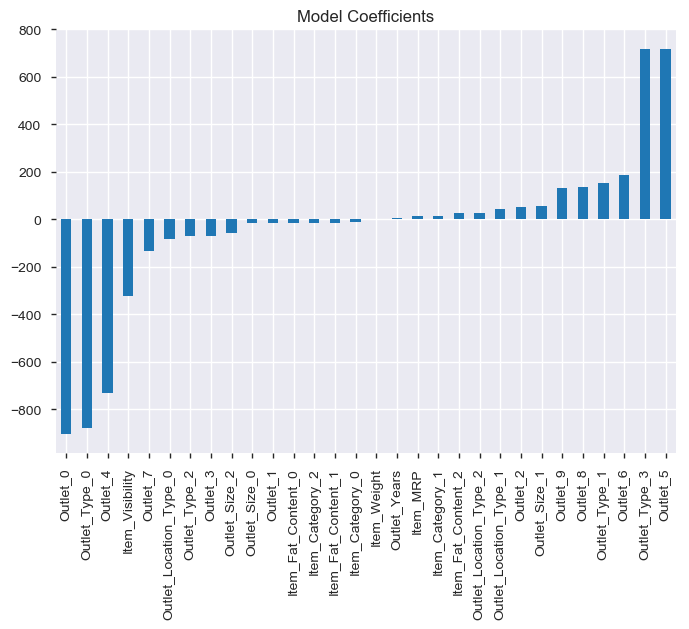

In [35]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

# define predictor variables
predictors = [x for x in train_mod.columns if x not in [target]+IDcol]

# create model object
ridge_reg = Ridge(alpha = 0.05, normalize = True)

# apply model
fitTransform(ridge_reg, train_mod, test_mod, predictors, target, IDcol, dirOP+'Ridge Regression1.csv')

# calculate coefficient
coef = pd.Series(ridge_reg.coef_, predictors).sort_values()

# plot the outcome
coef.plot(kind='bar', title='Model Coefficients')


Model Report
RMSE : 1128
CV Score : Mean - 1127 | Std - 69.18 | Min - 990.6 | Max - 1306


C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


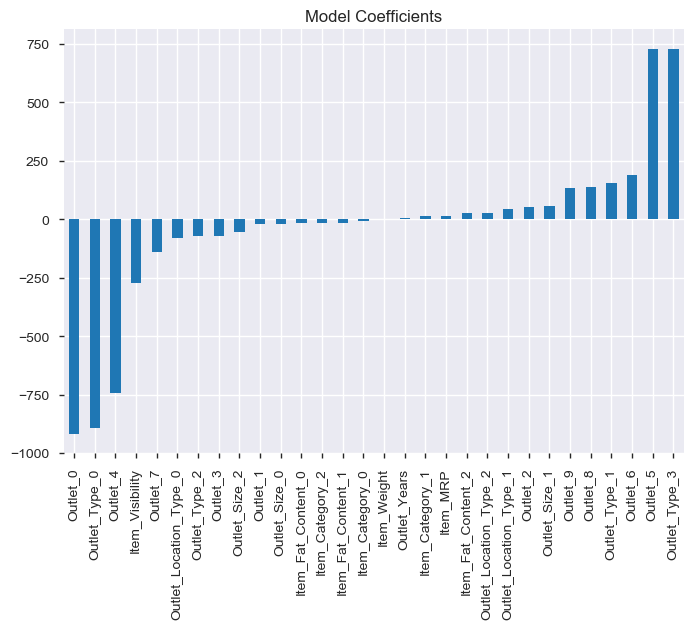

In [36]:
# create model object
ridge_reg = Ridge(alpha = 0.02, normalize = True)

# apply model
fitTransform(ridge_reg, train_mod, test_mod, predictors, target, IDcol, dirOP+'Ridge Regression2.csv')

# calculate coefficient
coef = pd.Series(ridge_reg.coef_, predictors).sort_values()

# plot the outcome
coef.plot(kind='bar', title='Model Coefficients')

This solution has been run multiple times for different values of alpha. The impact on RMSE is minimal. Therefore, I decided that the performance of Ridge regression has reached a plateau as far as this data is concerned.

#### Random Forest

I wanted to generalize the model to treat the test file better and eliminate overfitting, if any. Considering there is no situation where Random Forest is not at least somewhat useful, I decided to evaluate Random Forest.


Model Report
RMSE : 1068
CV Score : Mean - 1080 | Std - 67.07 | Min - 961.5 | Max - 1259


C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


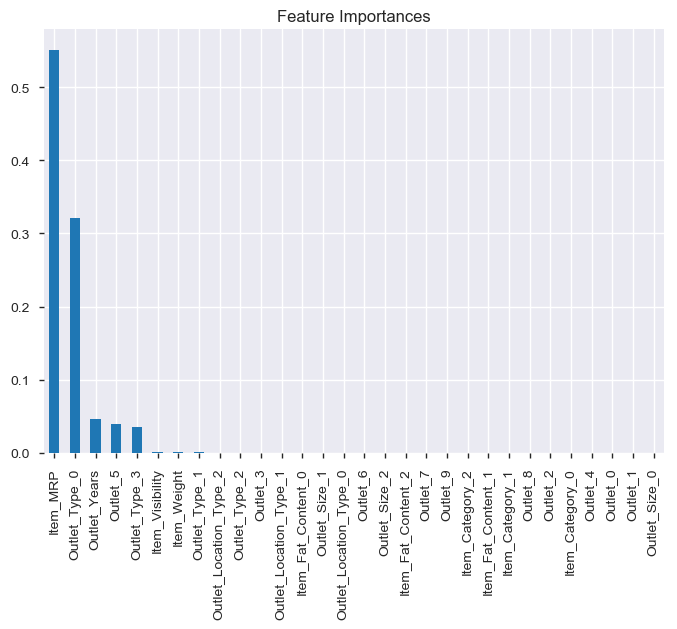

In [47]:
# create model object
randfor = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)

# apply model
fitTransform(randfor, train_mod, test_mod, predictors, target, IDcol, 'Random Forest1.csv')

# calculate coefficient
coef = pd.Series(randfor.feature_importances_, predictors).sort_values(ascending=False)

# plot the outcome
coef.plot(kind='bar', title='Feature Importances')

The RMSE improved quite a lot. By tuning the estimator, maximum tree depth, leaf nodes etc. parameter, this score could be slightly improved. But for the sale of concluding remark, I take this as the final result.

Concludingly, `Item_MRP`, `Outlet_Type_0`, `Outlet_Years`, `Outlet_5` and `Outlet_Type_3` are the most important features affecting the sales price of a product.